<a href="https://colab.research.google.com/github/MarioDudjak/LABUS-BeatCode/blob/main/LABUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beat Code: Generiranje glazbe uz strojno učenje

U ovoj radionici naučit ćemo kako koristiti Python i strojno učenje za generiranje glazbe. Istražit ćemo osnovne tehnike i alate potrebne za ovaj proces. Na kraju, sudionici će imati priliku stvoriti vlastite glazbene kompozicije koristeći programski kod.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1A9BXbT9UxlNqGHUOkWXSgJHwpRrF2PHC?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Pokreni unutar Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MarioDudjak/LABUS-BeatCode/blob/main/LABUS.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Pogledaj izvorni kod na GitHubu</a>
  </td>
</table>

## Postavke okruženja

In [33]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [34]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Preuzimanje Maestro skupa podataka

U ovoj radionici izgradit ćemo model strojnog učenja temeljen na umjetnoj neuronskoj mreži za generiranje glazbenih nota. Model će biti treniran na zbirci klavirskih audiozapisa iz [MAESTRO](https://magenta.tensorflow.org/datasets/maestro) skupa podataka, pohranjenih kao MIDI datoteke. Model će učiti predviđati sljedeću notu u nizu na temelju prethodnih nota. Na taj način, dulje sekvence nota mogu se generirati višestrukim pozivanjem modela.

In [35]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

Ovaj skup podataka sadrži više od 1,200 MIDI datoteka.

In [36]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Broj datoteka:', len(filenames))
sample_file = filenames[0]
print("Primjer jedne MIDI datoteke: ", sample_file)

Broj datoteka: 1282
Primjer jedne MIDI datoteke:  data/maestro-v2.0.0/2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--3.midi


## Predobrada MIDI datoteka

Najprije je potrebno koristiti biblioteku ```pretty_midi``` za parsiranje MIDI datoteka i provjeru formata nota. Ako želite preuzeti MIDI datoteku na svoje računalo radi reprodukcije, to možete učiniti unutar Colaba pomoću naredbe ```files.download(sample_file)```.

Zatim generiraje objekt `PrettyMIDI` za uzorkovanje MIDI datoteka.


In [37]:
# sample_file je ogledna (odnosno prva, s indeksom 0) datoteka iz skupa podataka
pm = pretty_midi.PrettyMIDI(sample_file)

Reproducirajte oglednu datoteku. Učitavanje widgeta za reprodukciju može trajati nekoliko sekundi.

In [38]:
# Sampling rate za audio reprodukciju - koliko snapshotova (u kHz) analognog zvučnog signala se uzima u jednoj sekundi za prebacivanje u digitalni zvuk (kao primjerice FPS kod videa)
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=20):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Uzmite uzorak generiranog valnog oblika u zadanom trajanju
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

Provjerite MIDI datoteku. Koji su instrumenti korišteni?

In [39]:
print('Broj korištenih instrumenata:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Naziv instrumenta:', instrument_name)
print('Broj nota u audiozapisu:', len(instrument.notes))

Broj korištenih instrumenata: 1
Naziv instrumenta: Acoustic Grand Piano
Broj nota u audiozapisu: 2774


## Izdvajanje nota

In [40]:
# Prikazat će se samo podaci o prvih 10 nota kako bi se izbjeglo pretrpavanje informacijama
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=42, note_name=F#2, duration=1.2904
1: pitch=35, note_name=B1, duration=1.3451
2: pitch=68, note_name=G#4, duration=0.3737
3: pitch=66, note_name=F#4, duration=0.3893
4: pitch=56, note_name=G#3, duration=0.4388
5: pitch=54, note_name=F#3, duration=2.2956
6: pitch=47, note_name=B2, duration=2.3086
7: pitch=47, note_name=B2, duration=0.9570
8: pitch=54, note_name=F#3, duration=1.0117
9: pitch=35, note_name=B1, duration=1.1224


Tijekom treniranja modela koristit ćemo tri varijable za predstavljanje nota: `pitch`, `step` i `duration`. Visina (`pitch`) predstavlja percepcijsku kvalitetu zvuka, izraženu kao broj note. Korak (`step`) označava vrijeme proteklo od prethodne note ili početka zapisa. Trajanje (`duration`) označava koliko dugo nota svira, odnosno razliku između vremena početka i završetka note.

Najprije izdvojite pojedine note iz MIDI datoteke.

In [41]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,42,0.950521,2.240885,0.000000,1.290365
1,35,0.957031,2.302083,0.006510,1.345052
2,54,2.083333,4.378906,1.126302,2.295573
3,47,2.087240,4.395833,0.003906,2.308594
4,56,3.660156,4.098958,1.572917,0.438802


Možda će biti lakše razumjeti nazive nota nego numeričke vrijednosti visine, pa možete koristiti funkciju u nastavku za pretvaranje tih vrijednosti u nazive nota. Naziv note uključuju vrste note, oznaku za povisilicu ili snizilicu te broj oktave (npr. C#4).

In [42]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#2', 'B1', 'F#3', 'B2', 'G#3', 'F#4', 'G#4', 'F#3', 'B2', 'F#2'],
      dtype='<U3')

Za vizualizaciju glazbenog dijela, iscrtajte visinu, početak i kraj svake note duž trajanja zapisa.

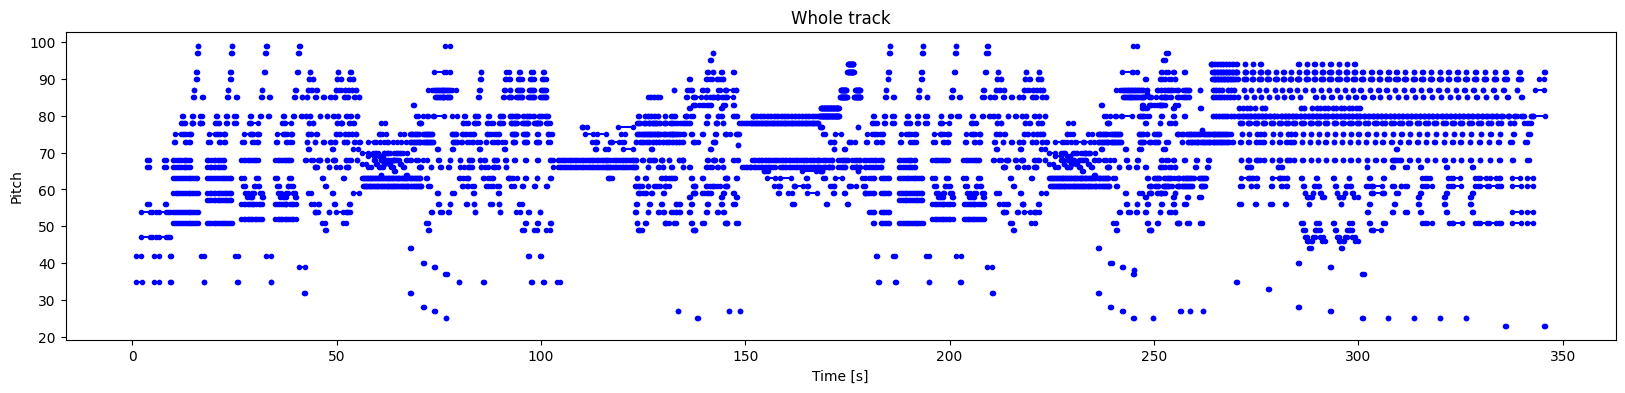

In [43]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes)

## Izrada skupa podataka za treniranje


Stvorite skup podataka za treniranje modela izdvajanjem nota iz MIDI datoteka. Možete započeti s malim brojem datoteka (primjerice, pet), a kasnije eksperimentirati s većim brojem. Ovaj proces može potrajati nekoliko minuta.

In [44]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print('Broj parsiranih nota:', n_notes)
all_notes.head(10)

Broj parsiranih nota: 16689


,pitch,start,end,step,duration
0,42,0.950521,2.240885,0.000000,1.290365
1,35,0.957031,2.302083,0.006510,1.345052
2,54,2.083333,4.378906,1.126302,2.295573
3,47,2.087240,4.395833,0.003906,2.308594
4,56,3.660156,4.098958,1.572917,0.438802
5,66,3.667969,4.057292,0.007812,0.389323
6,68,3.673177,4.046875,0.005208,0.373698
7,54,4.766927,5.778646,1.093750,1.011719
8,47,4.776042,5.733073,0.009115,0.957031
9,42,5.389323,6.587240,0.613281,1.197917


Nadalje, stvorite `tf.data.Dataset` iz izdvojenih nota.

In [45]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Trenirat ćemo model koristeći serije nizova nota. Svaki primjer sastojat će se od niza nota kao ulaznih značajki i sljedeće note kao oznake. Na taj način, model će se osposobiti za predviđanje sljedeće note u nizu. Moguće je koristiti funkciju prozora s veličinom `seq_length` za stvaranje značajki i oznaka u ovom formatu.



In [46]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Vraća TF Dataset od serije nizova nota i primjera oznaka."""
  seq_length = seq_length+1

  # Uzima se jedan dodatni prozor zbog oznaka
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` izravnava skup podataka u skup tenzora
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalizacija značajke pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Podjela oznaka nota
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Postavite duljinu niza za svaki trening primjer. Eksperimentirajte s različitim duljinama (npr. 50, 100, 150) kako biste utvrditili koja najbolje odgovara podacima. Veličina vokabulara (`vocab_size`) postavljena je na 128, što predstavlja sve visine koje podržava `pretty_midi`.

In [47]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

Oblik skupa podataka je ```(seq_length,1)```, što znači da će model primiti `seq_length` nota kao ulaz i naučiti predvidjeti sljedeću notu kao izlaz.



In [48]:
for seq, target in seq_ds.take(1):
  print('Oblik slijeda:', seq.shape)
  print('Elementi slijeda:', seq)
  print()
  print('Izlazna oznaka:', target)

Oblik slijeda: (25, 3)
Elementi slijeda: tf.Tensor(
[[0.328125   0.         1.29036458]
 [0.2734375  0.00651042 1.34505208]
 [0.421875   1.12630208 2.29557292]
 [0.3671875  0.00390625 2.30859375]
 [0.4375     1.57291667 0.43880208]
 [0.515625   0.0078125  0.38932292]
 [0.53125    0.00520833 0.37369792]
 [0.421875   1.09375    1.01171875]
 [0.3671875  0.00911458 0.95703125]
 [0.328125   0.61328125 1.19791667]
 [0.2734375  0.02213542 1.12239583]
 [0.421875   1.046875   1.87369792]
 [0.3671875  0.01432292 1.88802083]
 [0.53125    1.40885417 0.32552083]
 [0.515625   0.01302083 0.36588542]
 [0.4375     0.0234375  0.36848958]
 [0.421875   0.89973958 0.53385417]
 [0.3671875  0.0234375  0.38020833]
 [0.328125   0.48828125 0.11328125]
 [0.2734375  0.01953125 0.08203125]
 [0.53125    0.60026042 0.28125   ]
 [0.515625   0.04557292 0.47526042]
 [0.4609375  0.00260417 0.60026042]
 [0.4921875  0.02994792 0.45572917]
 [0.3984375  0.0078125  0.48958333]], shape=(25, 3), dtype=float64)

Izlazna oznaka:

Skupite primjere i konfigurirajte skup podataka za izvedbu.

In [49]:
batch_size = 64
buffer_size = n_notes - seq_length  # broj primjera u skupu podataka
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Izgradnja i treniranje modela

Model će imati tri izlaza, po jedan za svaku značajku note (`pitch`, `step` i `duration`). Za korak (`step`) i trajanje (`duration`) koristit ćemo prilagođenu funkciju gubitka temeljenu na srednjoj kvadratnoj pogrešci, koja potiče model da predviđa nenegativne vrijednosti.

In [50]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 25, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │         67,584 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Trenirajte model.

In [51]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [52]:
%%time
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.3621
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


260/260 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.3040
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.3008
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.2988
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.2952
Restoring model weights from the end of the best epoch: 5.
CPU times: user 1min 26s, sys: 5.39 s, total: 1min 32s
Wall time: 1min 27s


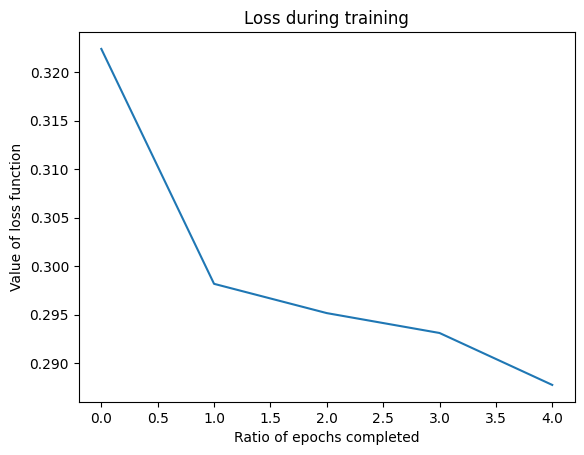

In [53]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.title('Loss during training')
plt.ylabel('Value of loss function')
plt.xlabel('Ratio of epochs completed')
plt.show()

## Generiranje nota

Da biste koristili model za generiranje nota, prvo ćete morati unijeti početni niz nota. Donja funkcija generira jednu notu iz tog niza pomoću treniranog modela.

In [54]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generira notu kao uređeni niz sastavljen od (pitch, step, duration), koristeći trenirani model."""

  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)
  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` i `duration` vrijednosti trebaju biti nenegativne
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Sada generirajte neke note. Možete eksperimentirati s vrijednošću parametra `temperature` i početnim nizom u funkciji `next_notes` kako biste vidjeli kakvi će rezultati nastati. Parametar `temperature` može se koristiti za kontrolu slučajnosti generiranih nota.

In [55]:
# Kod za promjenu ulaznog niza nota na temelju kojeg se radi predviđanje
# sample_file = filenames[0] # Ovdje promijenite indeks u polju MIDI datoteka
# pm = pretty_midi.PrettyMIDI(sample_file)
# raw_notes = midi_to_notes(sample_file)
# Ponovno pokrenite donju ćeliju

In [56]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━

In [57]:
# Ispis vrijednosti značajki predviđenih nota (prvih 10)
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.256684,0.416706,0.256684,0.673391
1,92,0.373222,0.164326,0.629906,0.794232
2,92,0.428227,0.168940,1.058133,1.227073
3,80,0.425624,0.169301,1.483757,1.653058
4,85,0.434998,0.174525,1.918754,2.093279
5,80,0.429184,0.165117,2.347939,2.513055
6,75,0.436925,0.163217,2.784863,2.948080
7,85,0.446505,0.161168,3.231368,3.392536
8,63,0.439237,0.145303,3.670605,3.815908
9,85,0.470249,0.162138,4.140854,4.302992


## Stvaranje MIDI datoteka
Možete generirati vlastitu MIDI datoteku s popisa nota pomoću donje funkcije i treniranog modela.

In [58]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # glasnoća note (može se mijenjati)
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm, seconds=20)

In [59]:
# Također možete preuzeti audio datoteku dodavanjem ovih redaka:

# from google.colab import files
# files.download(out_file)

Vizualizirajmo generirane note.

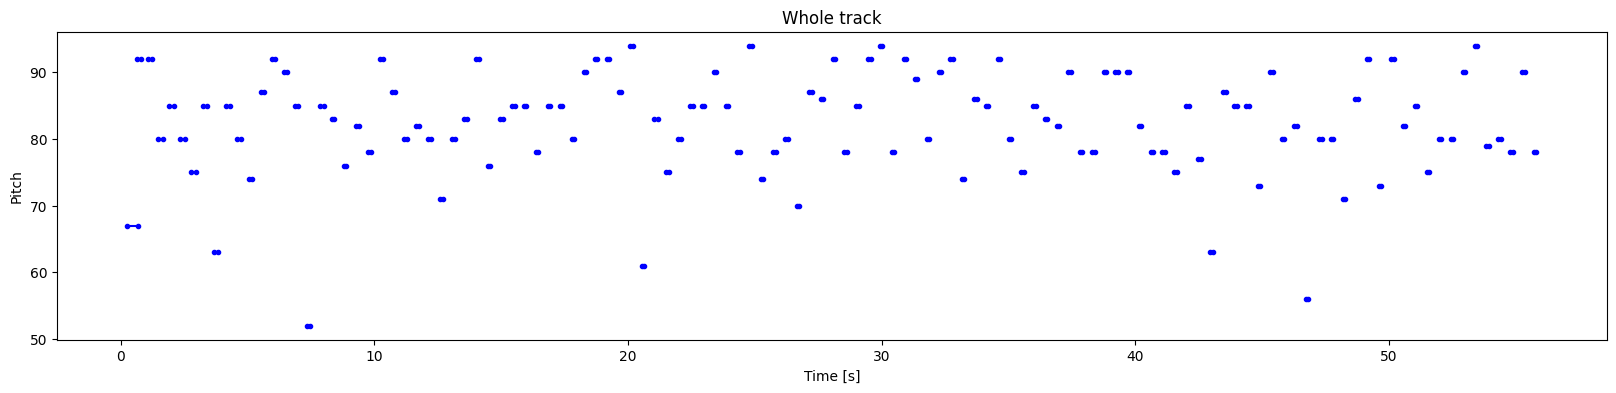

In [60]:
plot_piano_roll(generated_notes)